In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN


# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Validation
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from collections import Counter


In [38]:
def precision_recall_plot(true_label, prediction_prob):
    from inspect import signature
    step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
    
    from sklearn.metrics import average_precision_score
    average_precision = average_precision_score(true_label, prediction_prob)
    
    from sklearn.metrics import precision_recall_curve
    precision, recall, thresholds = precision_recall_curve(true_label, prediction_prob)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Binary Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    

# Dataset

In [3]:
merge=pd.read_csv('merge_test.csv')
# remove unnecessary column
merge = merge.drop('Unnamed: 0', axis=1)
# transfrom boolean column into string column
merge.idDetected = merge.idDetected.astype('str')
# dummy codes
merge = pd.get_dummies(merge, drop_first=True)
merge.head()


,age,hired,time_whole_conversation(hour),total_message_count,incoming_count,outgoing_count,responding,experience_yes,education_yes,bikeSurvey_yes,idDetected_True,drivingLicenseSurvey_yes
0,25.0,0,4238,149,57,92,4.504703e+05,1,1,1,1,1
1,20.0,0,2746,156,58,98,3.035038e+05,1,1,1,1,1
2,24.0,0,3722,92,33,59,3.426029e+05,1,1,1,1,1
3,22.0,0,3617,97,35,62,9.442864e+05,1,1,1,1,1
4,19.0,0,2689,83,30,53,1.033980e+06,1,1,1,1,1


In [4]:
X = merge.drop('hired', axis=1)
y = merge['hired']


# Train and test split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)


In [21]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)


# [over-sampling] Random over sampler

In [22]:
print(sorted(Counter(y_train).items()))


[(0, 7344), (1, 29)]


In [23]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train_std, y_train)


In [24]:
print(sorted(Counter(y_resampled).items()))


[(0, 7344), (1, 7344)]


# Logistics

In [31]:
# start with a really basic model
logit = LogisticRegression(C=100, random_state=1, solver='lbfgs', max_iter=1000)

# train the model
logit.fit(X_resampled, y_resampled)


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
y_pred = logit.predict(X_test_std)
y_pred_prob = logit.predict_proba(X_test_std)[:,1]


### Logistics_validation

In [36]:
confusion_matrix(y_test, y_pred)


array([[2218,  931],
       [   3,    9]])

In [37]:
print(classification_report(y_test, y_pred, target_names=['nothired', 'hired']))


              precision    recall  f1-score   support

    nothired       1.00      0.70      0.83      3149
       hired       0.01      0.75      0.02        12

    accuracy                           0.70      3161
   macro avg       0.50      0.73      0.42      3161
weighted avg       0.99      0.70      0.82      3161



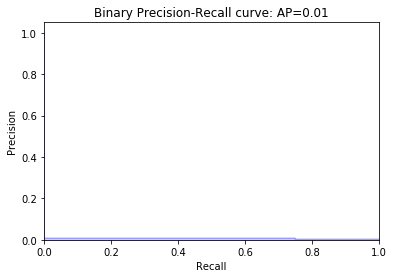

In [39]:
precision_recall_plot(y_test, y_pred)


# RandomForest

In [42]:
RF = RandomForestClassifier(criterion='gini', n_estimators=25, random_state=1)
RF.fit(X_resampled, y_resampled)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [43]:
y_pred = RF.predict(X_test_std)
y_pred_prob = RF.predict_proba(X_test_std)[:,1]


### RF_validation

In [44]:
confusion_matrix(y_test, y_pred)


array([[3141,    8],
       [  12,    0]])

In [45]:
print(classification_report(y_test, y_pred, target_names=['nothired', 'hired']))


              precision    recall  f1-score   support

    nothired       1.00      1.00      1.00      3149
       hired       0.00      0.00      0.00        12

    accuracy                           0.99      3161
   macro avg       0.50      0.50      0.50      3161
weighted avg       0.99      0.99      0.99      3161



# [over-sampling] SMOTE

In [64]:
print(sorted(Counter(y_train).items()))


[(0, 7344), (1, 29)]


In [66]:
X_resampled, y_resampled = SMOTE().fit_resample(X_train_std, y_train)

In [67]:
print(sorted(Counter(y_resampled).items()))


[(0, 7344), (1, 7344)]


# Logistics

In [68]:
# start with a really basic model
logit = LogisticRegression(C=100, random_state=1, solver='lbfgs', max_iter=1000)

# train the model
logit.fit(X_resampled, y_resampled)


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [69]:
y_pred = logit.predict(X_test_std)
y_pred_prob = logit.predict_proba(X_test_std)[:,1]


### Logistics_validation

In [70]:
confusion_matrix(y_test, y_pred)


array([[2179,  970],
       [   2,   10]])

In [71]:
print(classification_report(y_test, y_pred, target_names=['nothired', 'hired']))


              precision    recall  f1-score   support

    nothired       1.00      0.69      0.82      3149
       hired       0.01      0.83      0.02        12

    accuracy                           0.69      3161
   macro avg       0.50      0.76      0.42      3161
weighted avg       1.00      0.69      0.81      3161



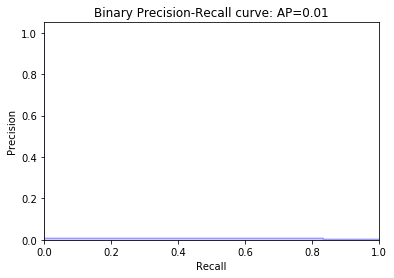

In [72]:
precision_recall_plot(y_test, y_pred)


# RandomForest

In [73]:
RF = RandomForestClassifier(criterion='gini', n_estimators=25, random_state=1)
RF.fit(X_resampled, y_resampled)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [74]:
y_pred = RF.predict(X_test_std)
y_pred_prob = RF.predict_proba(X_test_std)[:,1]


### RF_validation

In [75]:
confusion_matrix(y_test, y_pred)


array([[3103,   46],
       [   9,    3]])

In [76]:
print(classification_report(y_test, y_pred, target_names=['nothired', 'hired']))


              precision    recall  f1-score   support

    nothired       1.00      0.99      0.99      3149
       hired       0.06      0.25      0.10        12

    accuracy                           0.98      3161
   macro avg       0.53      0.62      0.54      3161
weighted avg       0.99      0.98      0.99      3161

